# Below is to prepare and cleanup the collected data from EJFAT and ERSAP for Digital Twin. 

In [99]:
import pandas as pd
import glob
from matplotlib import pyplot as plt

In [100]:
# remove outlier data points based on the z-score
def remove_outliers(df, columns, threshold=1):
    from scipy import stats
    import numpy as np
    z = np.abs(stats.zscore(df[columns]))
    outlier_indices = (z > threshold).any(axis=1)
    # get outlier indices
    return df[outlier_indices].index


In [101]:
dfs_event_rate = []
dfs_process_time = []
dfs_drop_total_events = []

for folder in glob.glob("*/"):
    fs = glob.glob(f"{folder}/*.csv")
    folder = folder.replace("dt-vol-", "").replace("/", "")
    for f in fs:
        df = pd.read_csv(f)

        if "currDropTotalEvents" in f:
            df.columns = ["time", "current-drop-total-event-rate"]
            # add a column of folder
                # remove "dt-vol" in folder name
            df["folder"] = folder
            dfs_drop_total_events.append(df)

        elif "Process Time" in f:
            df.columns = ["time", "process-time"]
            # the entry is like "1.22 ms", and remove the "ms" and convert to float
            df["process-time"] = df["process-time"].str.replace("ms", "").astype(float)
            title = "process-time"
            df["folder"] = folder
            dfs_process_time.append(df)

        elif "evRate" in f:
            df.columns = ["time", "event-rate"]
            title = "event-rate"
            df["folder"] = folder
            dfs_event_rate.append(df)

dfs_event_rate = pd.concat(dfs_event_rate, ignore_index=True)
dfs_process_time = pd.concat(dfs_process_time, ignore_index=True)
dfs_drop_total_events = pd.concat(dfs_drop_total_events, ignore_index=True)

# remove outliers
outliers = remove_outliers(dfs_process_time, ["process-time"], 1.5)
print(f"outliers: {outliers}")
## remove the rows with outliers
dfs_process_time = dfs_process_time.drop(outliers)
dfs_event_rate = dfs_event_rate.drop(outliers)
dfs_drop_total_events = dfs_drop_total_events.drop(outliers)

display(dfs_event_rate)
display(dfs_process_time)
display(dfs_drop_total_events)



outliers: Int64Index([ 23,  48,  50,  60,  63,  64,  80,  98, 105, 109, 112, 115, 116,
            123, 135, 238, 239, 240, 242, 252, 253, 264, 272, 279, 280, 281,
            285, 294, 312, 316, 332, 384, 446, 455, 491, 505, 510, 515, 517,
            522, 523, 528, 529, 532, 569, 573, 614],
           dtype='int64')


,time,event-rate,folder
0,2024-06-11 16:02:30,4310,1g-1node
1,2024-06-11 16:02:45,4296,1g-1node
2,2024-06-11 16:03:00,4295,1g-1node
3,2024-06-11 16:03:15,4302,1g-1node
4,2024-06-11 16:03:30,4301,1g-1node
...,...,...,...
618,2024-06-11 17:02:15,8598,2g-1node
619,2024-06-11 17:02:30,8615,2g-1node
620,2024-06-11 17:02:45,8605,2g-1node
621,2024-06-11 17:03:00,8610,2g-1node


,time,process-time,folder
0,2024-06-11 16:02:30,2.00,1g-1node
1,2024-06-11 16:02:45,1.84,1g-1node
2,2024-06-11 16:03:00,1.57,1g-1node
3,2024-06-11 16:03:15,1.82,1g-1node
4,2024-06-11 16:03:30,1.55,1g-1node
...,...,...,...
618,2024-06-11 17:02:15,1.47,2g-1node
619,2024-06-11 17:02:30,1.45,2g-1node
620,2024-06-11 17:02:45,1.51,2g-1node
621,2024-06-11 17:03:00,1.50,2g-1node


,time,current-drop-total-event-rate,folder
0,2024-06-11 16:02:30,0.422,1g-1node
1,2024-06-11 16:02:45,0.444,1g-1node
2,2024-06-11 16:03:00,0.511,1g-1node
3,2024-06-11 16:03:15,0.400,1g-1node
4,2024-06-11 16:03:30,0.378,1g-1node
...,...,...,...
618,2024-06-11 17:02:15,0.489,2g-1node
619,2024-06-11 17:02:30,0.644,2g-1node
620,2024-06-11 17:02:45,0.511,2g-1node
621,2024-06-11 17:03:00,0.556,2g-1node


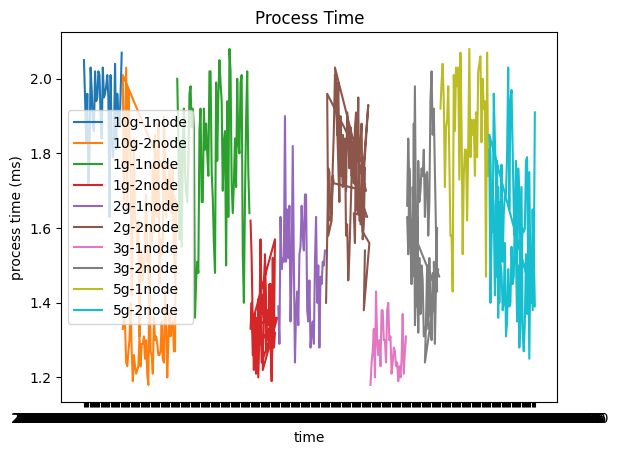

In [102]:
# plot process time
plt.figure()
for folder, df in dfs_process_time.groupby("folder"):
    plt.plot(df["time"], df["process-time"], label=folder)
plt.legend()
plt.title("Process Time")
plt.xlabel("time")
plt.ylabel("process time (ms)")
plt.show()


/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


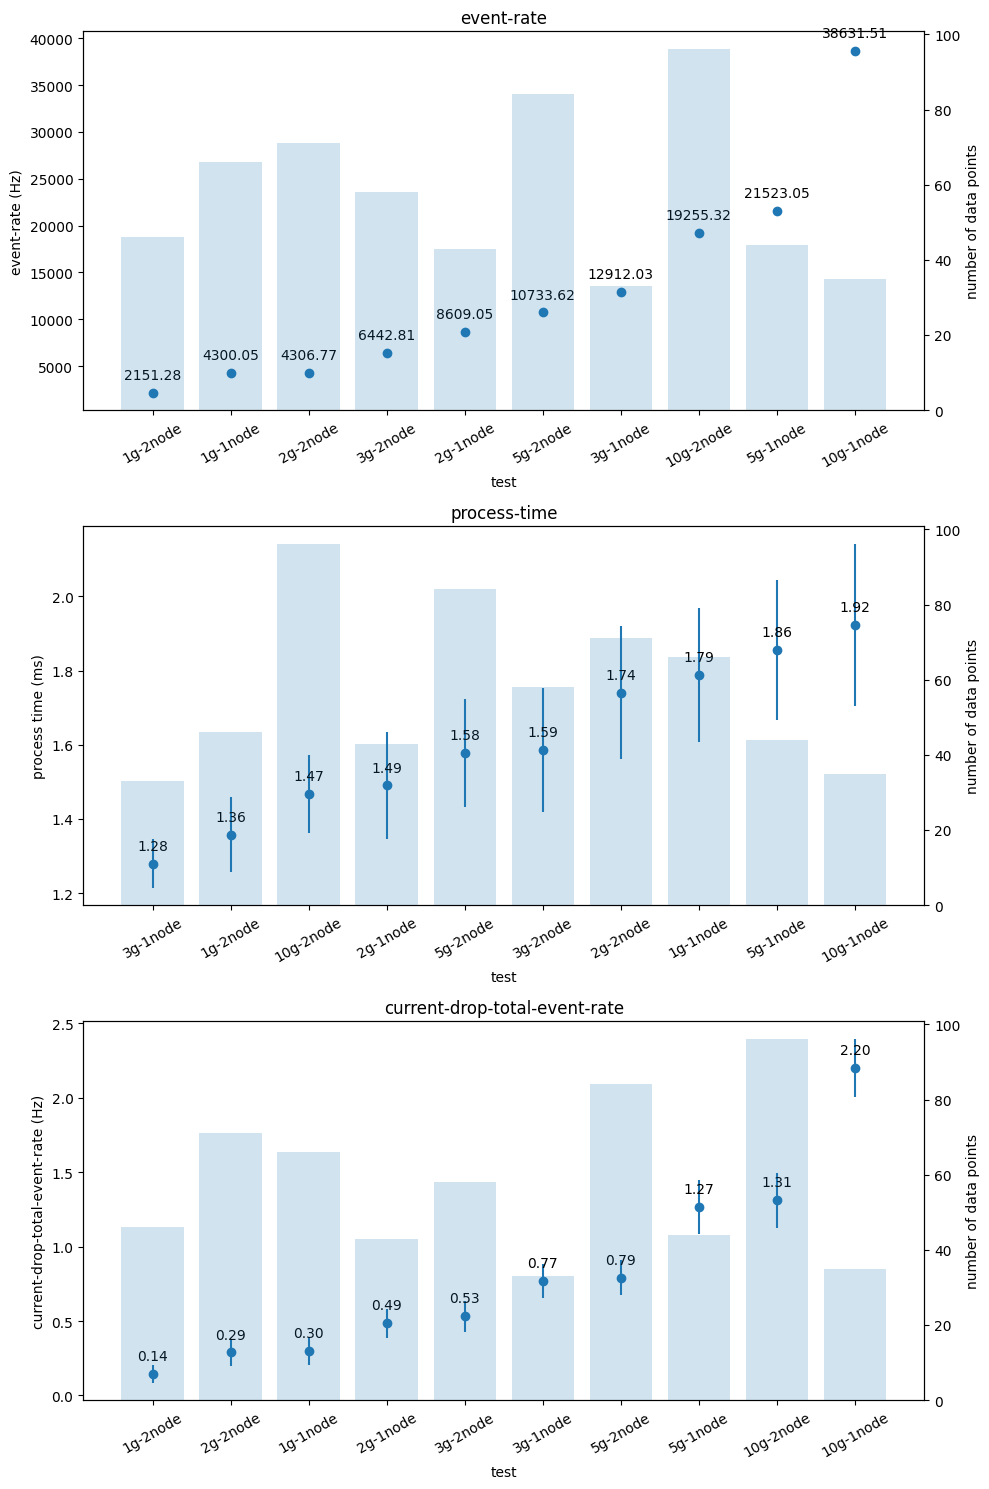

In [103]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

dataframes = [dfs_event_rate, dfs_process_time, dfs_drop_total_events]
for idx, df in enumerate(dataframes):
    # get the mean and std of each folder
    df_mean = df.groupby("folder").mean().sort_values(df.columns[1], ascending=True)
    df_std = df.groupby("folder").std().sort_values(df.columns[1], ascending=True)
    df_count = df.groupby("folder").size().sort_values(ascending=True)

    # plot mean and std of each folder in the same plot. The dot is the mean, and the error bar is the std centered at the mean
    axs[idx].errorbar(df_mean.index, df_mean[df.columns[1]], yerr=df_std[df.columns[1]], fmt='o')
    # annotate the percentage of the mean
    for i, txt in enumerate(df_mean[df.columns[1]]):
        axs[idx].annotate(f"{txt:.2f}", (i, txt), textcoords="offset points", xytext=(0,10), ha='center')
        
    axs[idx].set_xlabel("test")
    # make xlabel vertical
    axs[idx].set_xticklabels(df_mean.index, rotation=30)
    if "process-time" in df.columns[1]:
        axs[idx].set_ylabel("process time (ms)")
    else:
        axs[idx].set_ylabel(df.columns[1]+" (Hz)")
    axs[idx].set_title(df.columns[1])

    # plot the number of data points in each folder as a additional subplot
    ax2 = axs[idx].twinx()
    ax2.set_ylabel("number of data points")
    ax2.bar(df_mean.index, df_count.loc[df_mean.index], alpha=0.2)

plt.tight_layout()

plt.show()

# Below is for calculating Quantity of interest